### Basic Classes
Definition of basic classes required for the solution of the multi-armed bandit problem. Inspiration and code used from https://github.com/bgalbraith/bandits. The problem explanation can be better follwed in the chapter 2 of the book _“Reinforcement Learning, An Introduction”_ by Sutton and Barto  

In [6]:
# Inspired by https://github.com/bgalbraith/bandits
# Some part of the code were taken from this repository 
# and modified according to requirements of the current project.
# License of the project adjusted to be compliant with the used source.

import numpy as np

class MultiArmedBandit(object):
    """
    A Multi-armed Bandit
    """
    def __init__(self, k):
        self.k = k
        self.action_values = np.zeros(k)
        self.optimal = 0

    def reset(self):
        self.action_values = np.zeros(self.k)
        self.optimal = 0

    def pull(self, action):
        return 0, True
    
class MultiArmedBanditt(object):
    """
    A Multi-armed Bandit with independently customizable arms
    """
    def __init__(self, arms):
        self.arms = arms
        self.k = len(self.arms)
        self.action_values = np.zeros(len(arms))
        self.optimal = 0

    def reset(self):
        self.action_values = np.zeros(len(self.arms))
        self.optimal = 0
        for arm in self.arms:
            arm.reset()

    def pull(self, action):
        return self.arms[action].pull(), True

class Arm(object):
    """
    Representation of an arm to be used by a multiarmed bandit.
    By default this arm represent a random arm picking its values from a uniform distribution
    between 0 and 1.
    """
    def __init__(self):
        self.reset()
    
    def reset(self):
        self.count = 0 # counter of the times the arm is pulled
        
    def pull(self):
        self.count += 1
        return np.random.uniform();

class GaussianArm(Arm):
    """
    Representation of an arm using the values coming from a normal distribution
    """
    def __init__(self, mu=0, sigma=1):
        self.mu = mu
        self.mean = mu
        self.sigma = sigma
        super(GaussianArm, self).__init__()
        
    def __str__(self):
        return 'Gaussian Arm, mean=' + str(self.mean)
    
    def pull(self):
        self.count += 1
        return np.random.normal(self.mu, self.sigma)
    
class GaussianArm2(Arm):
    """
    Representation of an arm using the values coming from a normal distribution
    """
    def __init__(self, mu, sigma):
        self.mu = mu
        self.sigma = sigma
        self.reset()
    
    def __str__(self):
        return 'Gaussian Arm, mean=' + str(self.mean)
        
    def reset(self):
        self.count = 0
        self.mean = np.random.normal(self.mu, self.sigma)
    
    def pull(self):
        self.count += 1
        return np.random.normal(self.mean)

class Policy(object):
    """
    A policy prescribes an action to be taken based on the memory of an agent.
    """
    def __str__(self):
        return 'generic policy'

    def choose(self, agent, iteration):
        return 0


class EpsilonGreedyPolicy(Policy):
    """
    The Epsilon-Greedy policy will choose a random action with probability
    epsilon and take the best apparent approach with probability 1-epsilon. If
    multiple actions are tied for best choice, then a random action from that
    subset is selected.
    """
    def __init__(self, epsilon):
        self.epsilon = epsilon

    def __str__(self):
        return '\u03B5-greedy (\u03B5={})'.format(self.epsilon)

    def choose(self, agent, iteration = None):
        if np.random.random() < self.epsilon:
            return np.random.choice(len(agent.value_estimates))
        else:
            action = np.argmax(agent.value_estimates)
            check = np.where(agent.value_estimates == action)[0]
            if len(check) == 0:
                return action
            else:
                return np.random.choice(check)
            
class DynamicEpsilonGreedyPolicy(EpsilonGreedyPolicy):
    """
    Extended epsilon greedy policy with dynamic epsilon depending on the iteration number
    """
    def __str__(self):
        return 'Dynamic \u03B5-greedy'
    
    def choose(self, agent, iteration):
        epsilon = 1.0 / (iteration ** (0.5))
        if np.random.random() < epsilon:
            return np.random.choice(len(agent.value_estimates))
        else:
            action = np.argmax(agent.value_estimates)
            check = np.where(agent.value_estimates == action)[0]
            if len(check) == 0:
                return action
            else:
                return np.random.choice(check)

class RandomPolicy(Policy):
    """
    The Random policy randomly selects from all available actions with no
    consideration to which is apparently best. This can be seen as a special
    case of EpsilonGreedy where epsilon = 1 i.e. always explore. To avoid an
    additional call to numpy random function, the choose method is re-implemented
    as the copy of EpsilonGreedyPolicy without the condition evaluation.
    """
    def __str__(self):
        return 'random'
    
    def choose(self, agent, iteration = None):
        return np.random.choice(len(agent.value_estimates))
    
class SoftmaxPolicy(Policy):
    """
    The Softmax policy converts the estimated arm rewards into probabilities
    then randomly samples from the resultant distribution. This policy is
    primarily employed by the Gradient Agent for learning relative preferences.
    """
    
    def __init__(self, t):
        self.t = t
    
    def __str__(self):
        return 'SoftMax - t={}'.format(self.t)

    def choose(self, agent, iteration = None):
        numerator = np.exp(agent.value_estimates / self.t)
        denominator = np.sum(numerator)
        pdf = numerator / denominator #probability distribution function
        return np.random.choice(len(agent.value_estimates), p=pdf)

class DynamicSoftmaxPolicy(SoftmaxPolicy):
    """
    Extended softmax policy with dinamic temparature (t) value depending on the iteration number
    """
    
    def __str__(self):
        return 'Dynamic SoftMax'
    
    def choose(self, agent, iteration):
        t = 4 * ((1000 - iteration) / 1000)
        numerator = np.exp(agent.value_estimates / t)
        denominator = np.sum(numerator)
        pdf = numerator / denominator #probability distribution function
        return np.random.choice(len(agent.value_estimates), p=pdf)
    
class Agent(object):
    """
    An Agent is able to take one of a set of actions at each time step. The
    action is chosen using a strategy based on the history of prior actions
    and outcome observations.
    """
    def __init__(self, bandit, policy, prior=0, gamma=None):
        self.policy = policy
        self.k = bandit.k
        self.bandit = bandit
        self.prior = prior
        self.gamma = gamma
        self._value_estimates = prior*np.ones(self.k)
        self.action_attempts = np.zeros(self.k)
        self.t = 0
        self.last_action = None

    def __str__(self):
        return '{}'.format(str(self.policy))

    def reset(self):
        """
        Resets the agent's memory to an initial state.
        """
        self._value_estimates[:] = self.prior
        self.action_attempts[:] = 0
        self.last_action = None
        self.t = 0
        self.bandit.reset()

    def choose(self, iteration):
        action = self.policy.choose(self, iteration)
        self.last_action = action
        return action

    def observe(self, reward):
        self.action_attempts[self.last_action] += 1

        if self.gamma is None:
            g = 1 / self.action_attempts[self.last_action]
        else:
            g = self.gamma
        q = self._value_estimates[self.last_action]

        self._value_estimates[self.last_action] += g*(reward - q)
        self.t += 1
        
    def obsrv(self, reward):
        self.action_attempts[self.last_action] += 1
        self._value_estimates[self.last_action] = (self._value_estimates[self.last_action] + reward) / 2
        self.t += 1

    @property
    def value_estimates(self):
        return self._value_estimates

### Runner
Definition of the class in charge of running the experiment. Defines a condition to stop the experiment and creates an instance of the required elements to run the simulation. It also defines the number of one-armed bandits that will be used in the simulation. In order to obtain meaningful results, the simulator has to run several times each experiment, obtaining an average of the results to work with. Thus, a parameter for the number of experiments is required.

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
#import seaborn as sns

class Simulator(object):
    def __init__(self, agents, iterations, experiments):
        self.agents = agents
        self.iterations = iterations
        self.experiments = experiments
    
    def reset(self):
        for agent in self.agents:
            agent.reset()
    
    def run(self):
        self.scores = np.zeros((self.iterations, len(self.agents)))
        self.optimal = np.zeros_like(self.scores)
        # Assuming that all the bandits in the experiment have the same arms distribution
        n_agents = len(self.agents)
        n_arms = self.agents[0].bandit.k
        self.arms_selection_count = np.zeros(n_arms)
        self.arms_selection = []
        
        for xp in range(self.experiments):
            self.reset()
            list_arms_selected = []
            for t in range(self.iterations):
                for i, agent in enumerate(self.agents):
                    action = agent.choose(t)
                    reward, is_optimal = agent.bandit.pull(action)
                    #agent.observe(reward)
                    agent.obsrv(reward)

                    self.scores[t, i] += reward
                    list_arms_selected.append((action, reward))
                    if is_optimal:
                        self.optimal[t, i] += 1
                    self.arms_selection_count[action] += 1
            self.arms_selection.append(list_arms_selected)
        
        self.arms_selection_count = self.arms_selection_count / (self.experiments * n_agents)
        self.scores = self.scores / self.experiments
        self.optimal = self.optimal / self.experiments
    
    def run2(self):
        self.scores = np.zeros((self.iterations, len(self.agents)))
        self.optimal = np.zeros_like(self.scores)
        # Assuming that all the bandits in the experiment have the same arms distribution
        n_agents = len(self.agents)
        n_arms = self.agents[0].bandit.k
        self.arms_selection_count = np.zeros(n_arms)
        self.arms_selection = []
        
        for i, agent in enumerate(self.agents):
            
            arms_selection_count_l = np.zeros(n_arms)
            for xp in range(self.experiments):
                list_arms_selected = []
                self.reset()
                for t in range(self.iterations):
                    action = agent.choose(t+1)
                    reward, is_optimal = agent.bandit.pull(action)
                    #agent.observe(reward)
                    agent.obsrv(reward)

                    self.scores[t, i] += reward
                    list_arms_selected.append((action, reward))
                    if is_optimal:
                        self.optimal[t, i] += 1
                    self.arms_selection_count[action] += 1
                    arms_selection_count_l[action] += 1
                if xp == self.experiments - 1:
                    self.arms_selection.append(list_arms_selected)
            
            self.plot_arm_selection_histogram(arms_selection_count_l / self.experiments, str(agent))
        
        self.arms_selection_count = self.arms_selection_count / (self.experiments * n_agents)
        self.scores = self.scores / self.experiments
        self.optimal = self.optimal / self.experiments
    
    def plot_arm_selection_histogram_global(self):
        plt.subplot(1,1,1)
        #sns.set_style('white')
        #sns.set_context('talk')
        plt.title('Arm selection histogram')
        
        x_pos = np.arange(len(self.arms_selection_count))
        vals = self.arms_selection_count
        plt.bar(x_pos, vals,align='center')
        plt.xticks(x_pos, np.arange(1, len(self.arms_selection_count) + 1)) 
        #sns.despine()
        plt.show()
    
    def plot_arm_selection_histogram(self, arms_selection_count, agent_label):
        plt.subplot(1,1,1)
        #sns.set_style('white')
        #sns.set_context('talk')
        plt.title('Arm selection histogram - ' + agent_label)
        
        x_pos = np.arange(len(arms_selection_count))
        vals = arms_selection_count
        
        plt.bar(x_pos, vals,align='center')
        plt.xticks(x_pos, np.arange(1, len(arms_selection_count) + 1)) 
        #sns.despine()
        plt.show()
        
    def plot_agents_avg_reward(self):
        #sns.set_style('white')
        #sns.set_context('talk')
        plt.subplot(1, 1, 1)
        plt.title('Results')
        plt.plot(self.scores)
        plt.ylabel('Average Reward')
        plt.legend(self.agents, loc=4)
        plt.xlabel('Time Step')
        plt.legend(self.agents, loc=4)
        #sns.despine()
        plt.show()
    
    def plot_arm_rewards(self):
        iterations = []
        arm_values = []
        num_arms = self.agents[0].bandit.k
        
        for _ in range(num_arms):
            arm_values.append([])
            iterations.append([])
        
        for exp_vals in self.arms_selection:
            count = 0
            for iter_val in exp_vals:
                iterations[iter_val[0]].append(count % self.iterations + 1)
                arm_values[iter_val[0]].append(iter_val[1])
                count += 1
        
        for arm in range(num_arms):
            #self.plot_single_arm_reward(iterations[arm], arm_values[arm], self.agents[0].bandit.arms[arm].mu, str(arm+1))
            self.plot_single_arm_reward(iterations[arm], arm_values[arm], self.agents[0].bandit.arms[arm].mean, str(self.agents[0].bandit.arms[arm]))
    
    def plot_single_arm_reward(self, iterations, arm_values, arm_mean, arm_label):
        #sns.set_style('white')
        #sns.set_context('talk')
        plt.title('Estimate - Actual Values - ' + arm_label)
        plt.subplot(1, 1, 1)
        plt.plot(iterations, arm_values, 'ro', label='Actual')
        plt.axhline(y=arm_mean, xmin=0, xmax=1, hold=None, label='Estimate')
        plt.xlim([0, self.iterations + 1])
        plt.xlabel('Time Step')
        plt.xlabel('Reward')
        #sns.despine()
        plt.show()

### Exercise 1

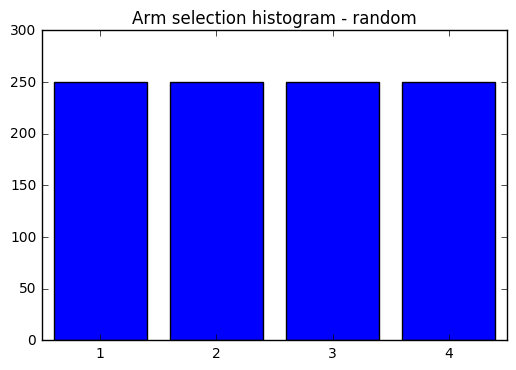

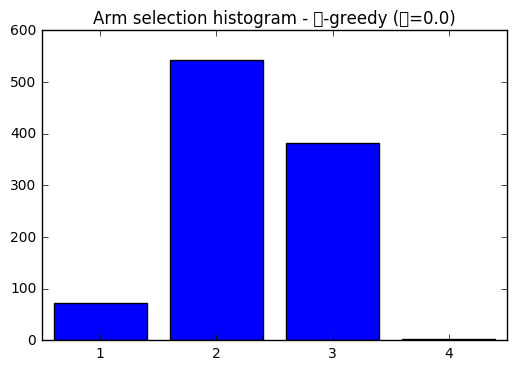

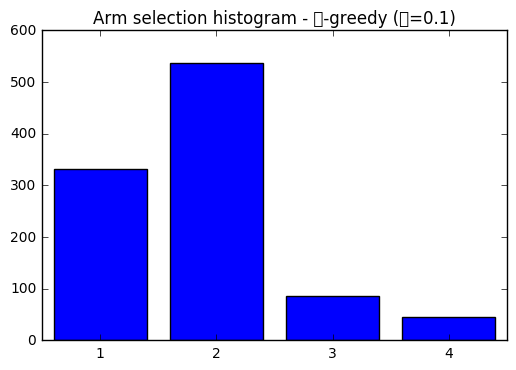

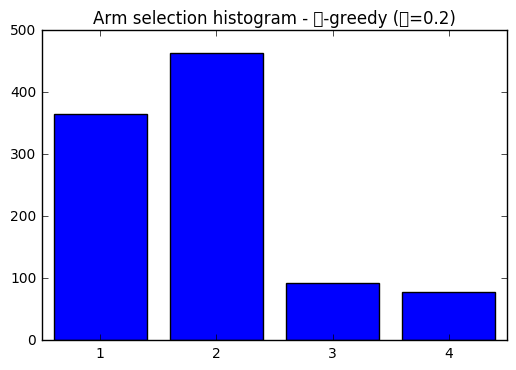

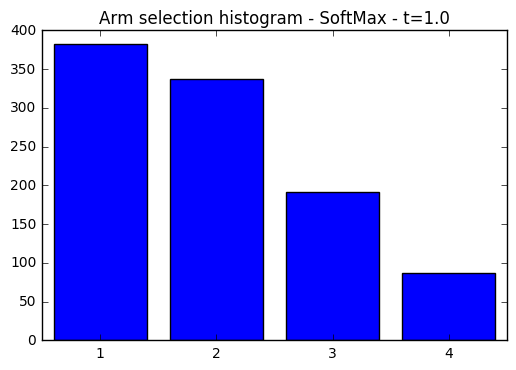

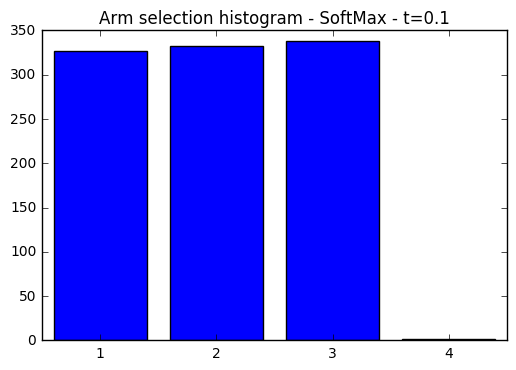

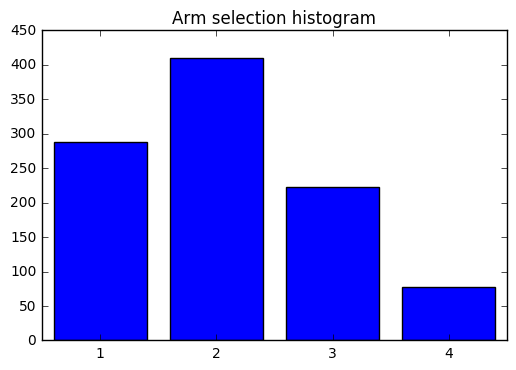

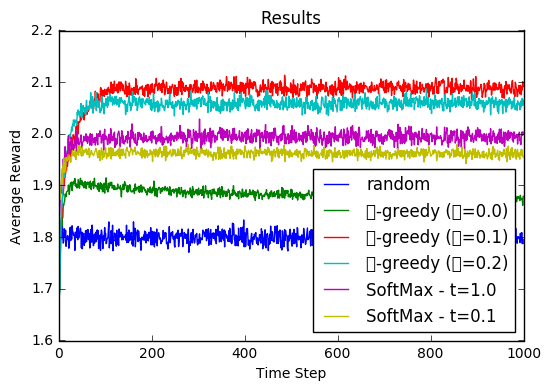

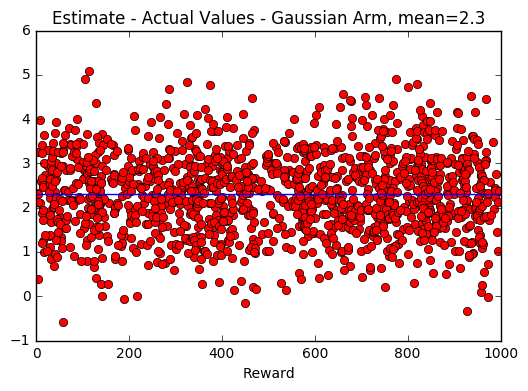

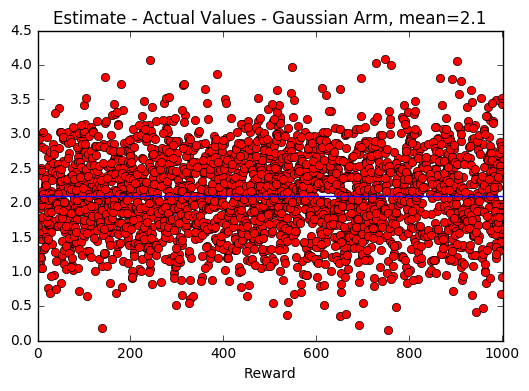

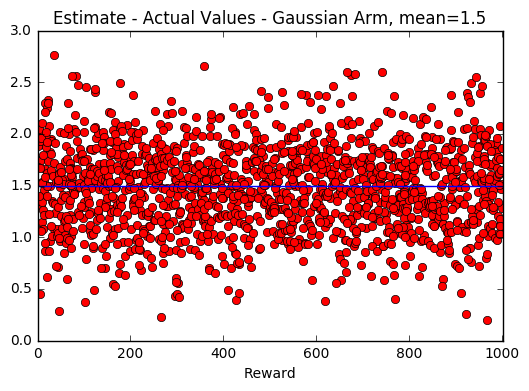

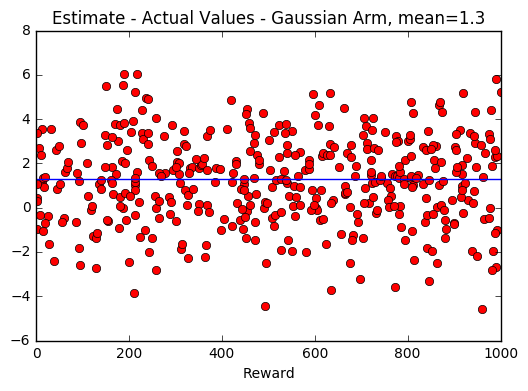

In [3]:
import copy


arms = [GaussianArm(2.3, 0.9),
        GaussianArm(2.1, 0.6),
        GaussianArm(1.5, 0.4),
        GaussianArm(1.3, 2.0)]
'''

arms = [GaussianArm2(2.3, 0.9),
        GaussianArm2(2.1, 0.6),
        GaussianArm2(1.5, 0.4),
        GaussianArm2(1.3, 2.0)]
'''

agents = [Agent(MultiArmedBanditt(arms), RandomPolicy()),
          Agent(MultiArmedBanditt(copy.deepcopy(arms)), EpsilonGreedyPolicy(0.0)),
          Agent(MultiArmedBanditt(copy.deepcopy(arms)), EpsilonGreedyPolicy(0.1)),
          Agent(MultiArmedBanditt(copy.deepcopy(arms)), EpsilonGreedyPolicy(0.2)),
          Agent(MultiArmedBanditt(copy.deepcopy(arms)), SoftmaxPolicy(1.0)),
          Agent(MultiArmedBanditt(copy.deepcopy(arms)), SoftmaxPolicy(0.1))]

iterations = 1000
experiments = 12000

simulator = Simulator(agents, iterations, experiments)
simulator.run2()
simulator.plot_arm_selection_histogram_global()
simulator.plot_agents_avg_reward()
simulator.plot_arm_rewards()

### Exercise 2

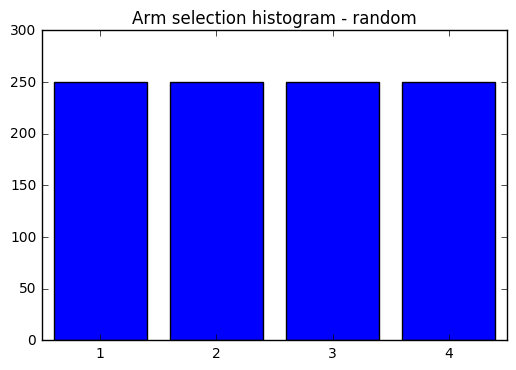

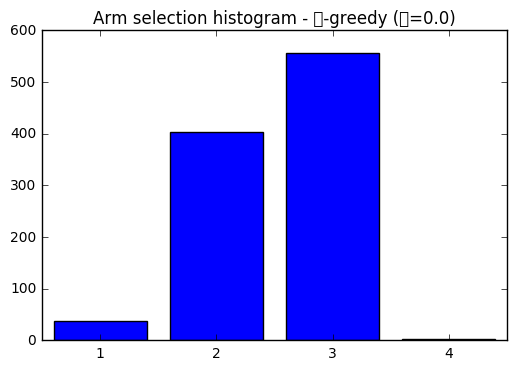

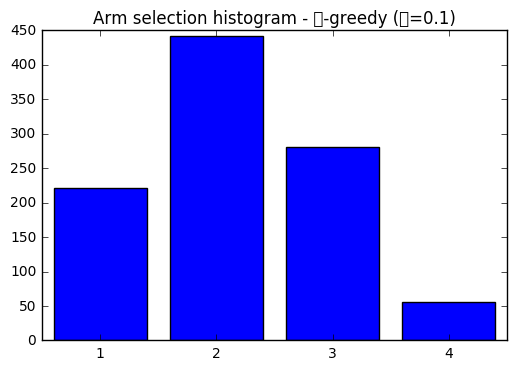

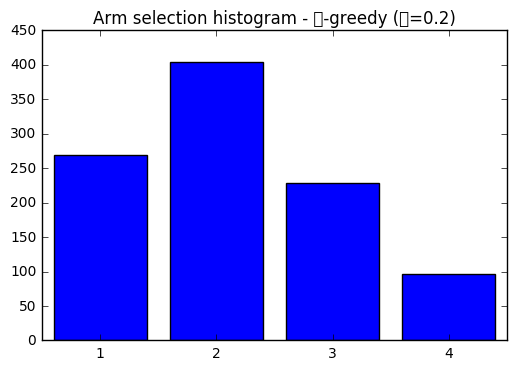

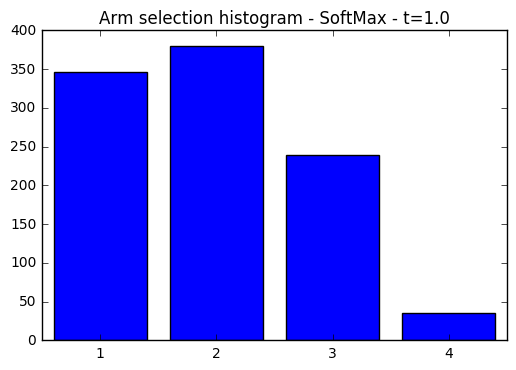

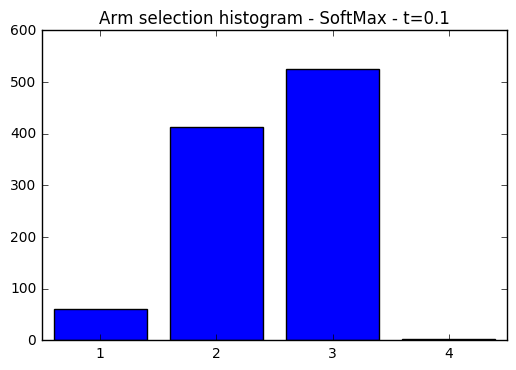

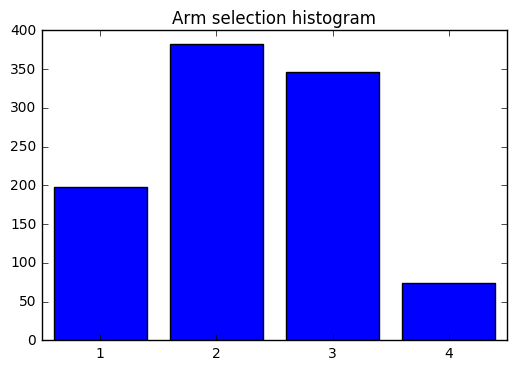

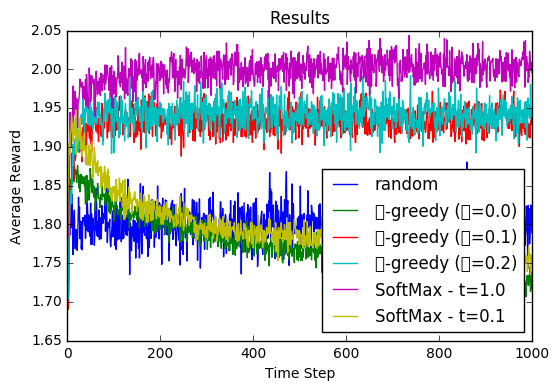

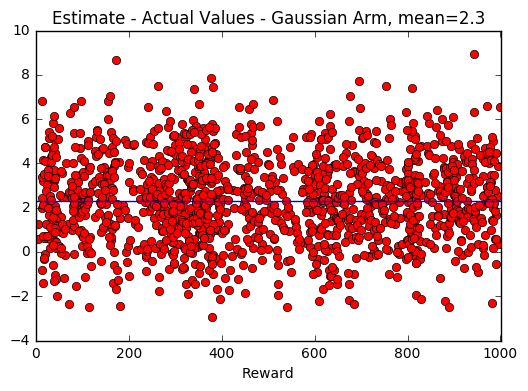

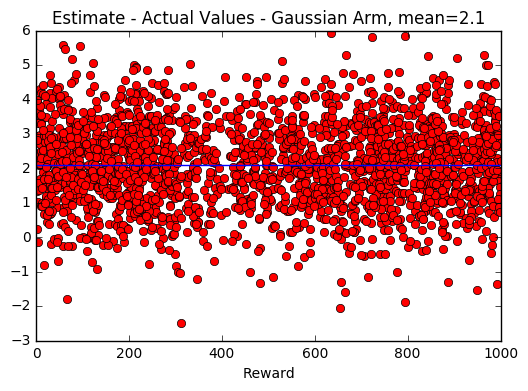

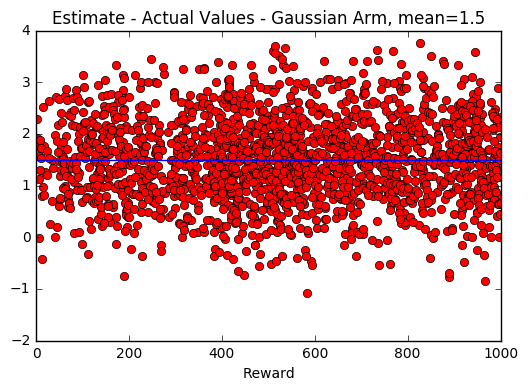

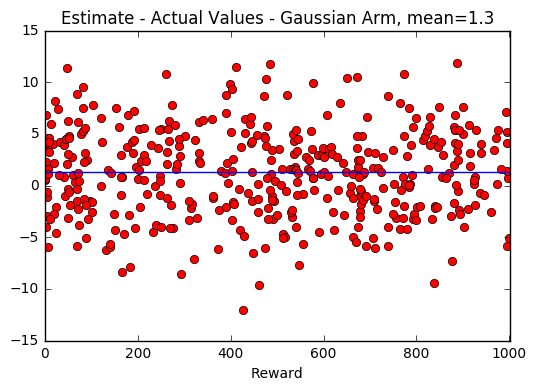

In [4]:
import copy


arms = [GaussianArm(2.3, 0.9 * 2),
        GaussianArm(2.1, 0.6 * 2),
        GaussianArm(1.5, 0.4 * 2),
        GaussianArm(1.3, 2.0 * 2)]
'''

arms = [GaussianArm2(2.3, 0.9),
        GaussianArm2(2.1, 0.6),
        GaussianArm2(1.5, 0.4),
        GaussianArm2(1.3, 2.0)]
'''

agents = [Agent(MultiArmedBanditt(arms), RandomPolicy()),
          Agent(MultiArmedBanditt(copy.deepcopy(arms)), EpsilonGreedyPolicy(0.0)),
          Agent(MultiArmedBanditt(copy.deepcopy(arms)), EpsilonGreedyPolicy(0.1)),
          Agent(MultiArmedBanditt(copy.deepcopy(arms)), EpsilonGreedyPolicy(0.2)),
          Agent(MultiArmedBanditt(copy.deepcopy(arms)), SoftmaxPolicy(1.0)),
          Agent(MultiArmedBanditt(copy.deepcopy(arms)), SoftmaxPolicy(0.1))]

iterations = 1000
experiments = 12000

simulator = Simulator(agents, iterations, experiments)
simulator.run2()
simulator.plot_arm_selection_histogram_global()
simulator.plot_agents_avg_reward()
simulator.plot_arm_rewards()

### Exercise 3

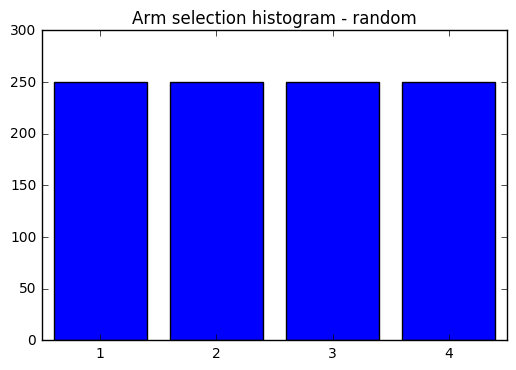

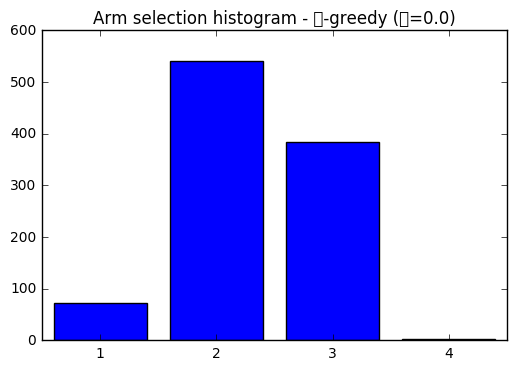

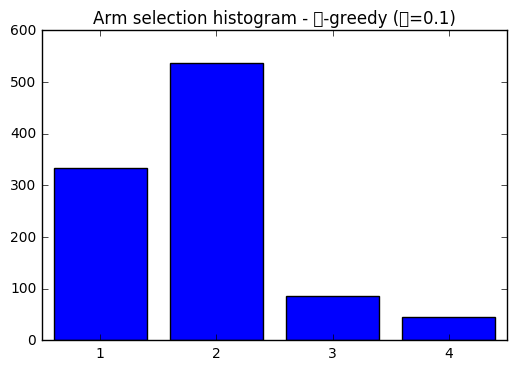

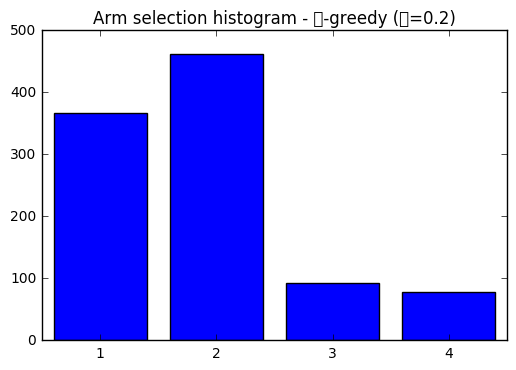

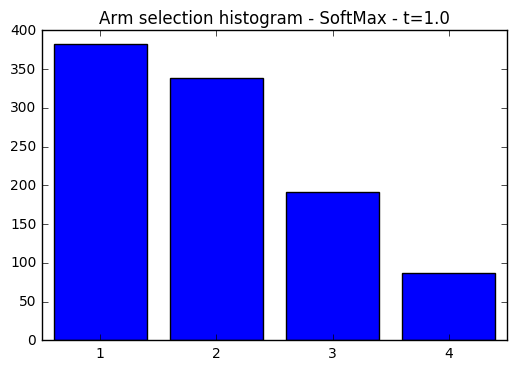

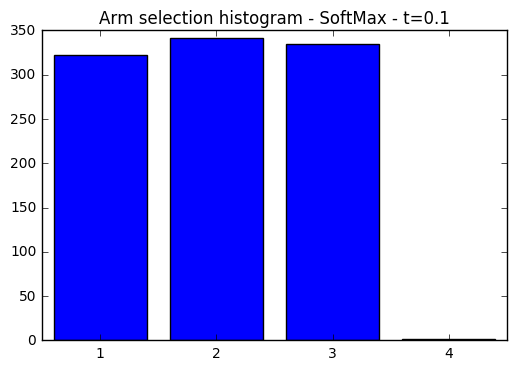

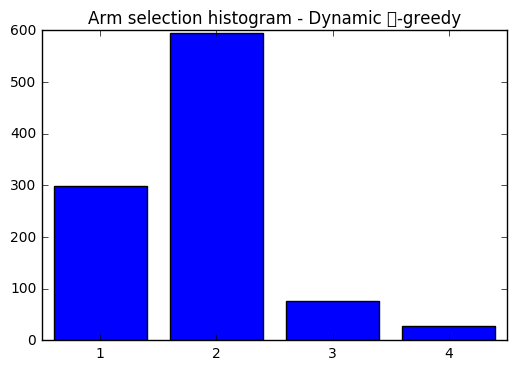

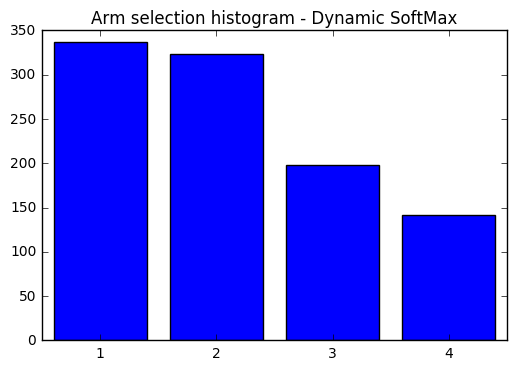

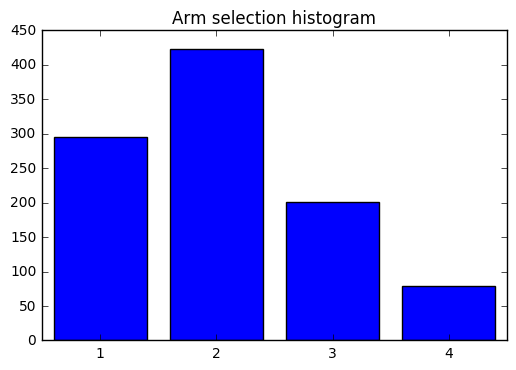

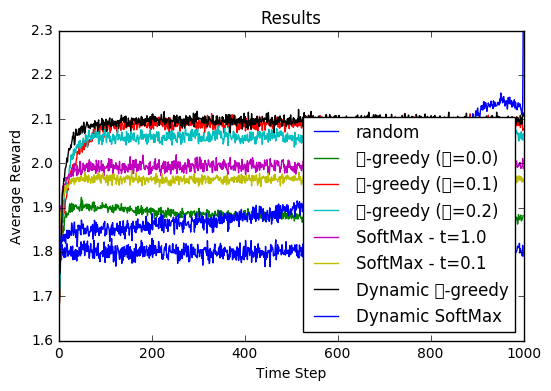

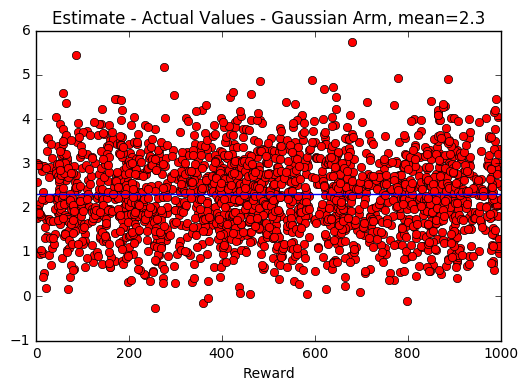

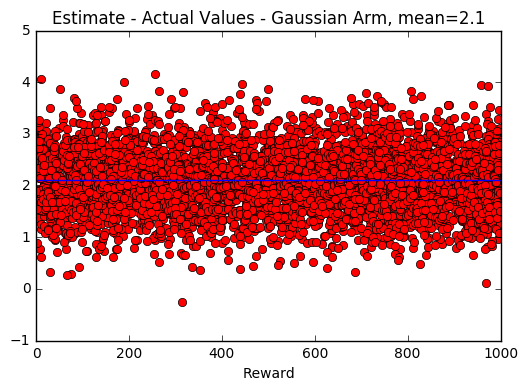

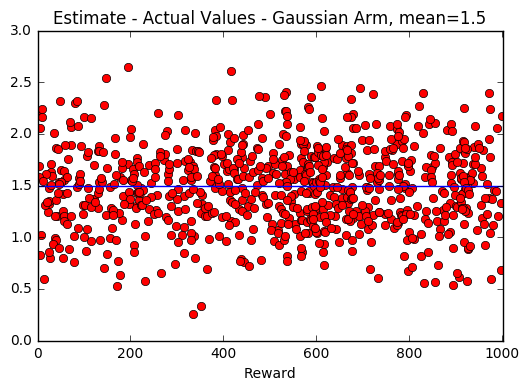

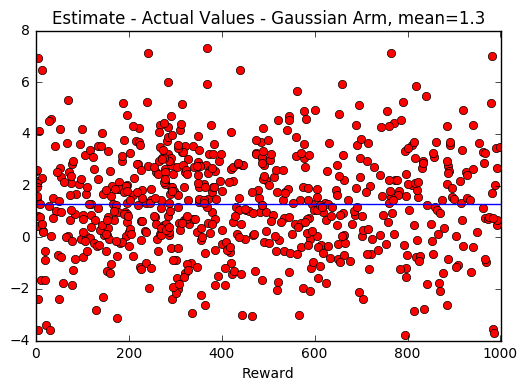

In [8]:
import copy


arms = [GaussianArm(2.3, 0.9),
        GaussianArm(2.1, 0.6),
        GaussianArm(1.5, 0.4),
        GaussianArm(1.3, 2.0)]
'''

arms = [GaussianArm2(2.3, 0.9),
        GaussianArm2(2.1, 0.6),
        GaussianArm2(1.5, 0.4),
        GaussianArm2(1.3, 2.0)]
'''

agents = [Agent(MultiArmedBanditt(arms), RandomPolicy()),
          Agent(MultiArmedBanditt(copy.deepcopy(arms)), EpsilonGreedyPolicy(0.0)),
          Agent(MultiArmedBanditt(copy.deepcopy(arms)), EpsilonGreedyPolicy(0.1)),
          Agent(MultiArmedBanditt(copy.deepcopy(arms)), EpsilonGreedyPolicy(0.2)),
          Agent(MultiArmedBanditt(copy.deepcopy(arms)), SoftmaxPolicy(1.0)),
          Agent(MultiArmedBanditt(copy.deepcopy(arms)), SoftmaxPolicy(0.1)),
          Agent(MultiArmedBanditt(copy.deepcopy(arms)), DynamicEpsilonGreedyPolicy(None)),
          Agent(MultiArmedBanditt(copy.deepcopy(arms)), DynamicSoftmaxPolicy(None))]

iterations = 1000
experiments = 12000

simulator = Simulator(agents, iterations, experiments)
simulator.run2()
simulator.plot_arm_selection_histogram_global()
simulator.plot_agents_avg_reward()
simulator.plot_arm_rewards()